# Airbnb Predictive Modeling

This notebook performs a predictive modeling analysis on a multi-region Airbnb dataset including Rhode Island, Boston, Cambridge, and New York City. The dataset includes listings, reviews, and neighbourhoods data.

The goal is to predict estimated revenue using property, host, location, review, and textual features. The notebook includes full data cleaning, EDA, feature engineering, sentiment analysis, and model evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob
import os
import warnings
warnings.filterwarnings("ignore")

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

## Data Loading

In [2]:
def load_files(data_dir, file_suffix):
    pattern = os.path.join(data_dir, f"*_{file_suffix}.csv")
    files = glob.glob(pattern)
    dfs = []
    for file in files:
        region = os.path.basename(file).replace(f"_{file_suffix}.csv", "").replace(".csv", "")
        df = pd.read_csv(file)
        df['region'] = region.capitalize()
        dfs.append(df)
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()

data_dir = '.'

listings = load_files(data_dir, 'listings')
reviews = load_files(data_dir, 'reviews')

print("Listings shape:", listings.shape)
print("Reviews shape:", reviews.shape)

Listings shape: (48433, 80)
Reviews shape: (1518493, 7)


## Data Cleaning and Preparation

In [3]:
# Drop columns with excessive missing values
high_missing_cols = [
    'calendar_updated', 'license', 'host_about', 'neighborhood_overview',
    'neighbourhood', 'host_location'
]
listings = listings.drop(columns=high_missing_cols, errors='ignore')

listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings['estimated_revenue_l365d'] = pd.to_numeric(listings['estimated_revenue_l365d'], errors='coerce')
listings['estimated_occupancy_l365d'] = pd.to_numeric(listings['estimated_occupancy_l365d'], errors='coerce')

listings = listings.dropna(subset=['estimated_revenue_l365d']).copy()

if 'host_since' in listings.columns:
    listings['host_since'] = pd.to_datetime(listings['host_since'])

for col in listings.columns:
    if col.startswith("review_scores_"):
        listings[col] = listings[col].fillna(listings[col].median())

In [4]:
analyzer = SentimentIntensityAnalyzer()

def compute_sentiment(text):
    if pd.isna(text):
        return 0.0
    return analyzer.polarity_scores(str(text))['compound']

reviews['sentiment'] = reviews['comments'].apply(compute_sentiment)

review_agg = reviews.groupby('listing_id').agg({
    'id': 'count',
    'sentiment': 'mean',
    'comments': lambda x: np.mean([len(str(c)) for c in x])
}).rename(columns={'id': 'review_count', 'comments': 'avg_review_length'})

data = listings.merge(review_agg, left_on='id', right_on='listing_id', how='left')

for col in ['review_count', 'sentiment', 'avg_review_length']:
    data[col] = data[col].fillna(0)

# These are already numeric but just ensure they're filled
for col in ['availability_30', 'availability_60', 'availability_90']:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(int)

# Remove unused columns
unused_cols = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'latitude', 'longitude', 'calendar_last_scraped']
data = data.drop(columns=unused_cols, errors='ignore')

## EDA

In [5]:
print(data['host_response_time'].value_counts(dropna=False))

print(data['property_type'].value_counts(dropna=False))

print(data['host_verifications'].value_counts(dropna=False))

print(data['host_is_superhost'].unique())

print(data['bathrooms_text'].unique())

host_response_time
within an hour        18514
within a few hours     4848
NaN                    4370
within a day           2395
a few days or more     1175
Name: count, dtype: int64
property_type
Entire rental unit             13043
Private room in rental unit     5972
Entire home                     3193
Private room in home            2506
Entire condo                    1240
                               ...  
Island                             1
Private room in barn               1
Lighthouse                         1
Treehouse                          1
Dome                               1
Name: count, Length: 74, dtype: int64
host_verifications
['email', 'phone']                  23759
['email', 'phone', 'work_email']     4690
['phone']                            2704
['phone', 'work_email']               122
['email']                              16
NaN                                     7
[]                                      4
Name: count, dtype: int64
['f' 't' nan]
['1

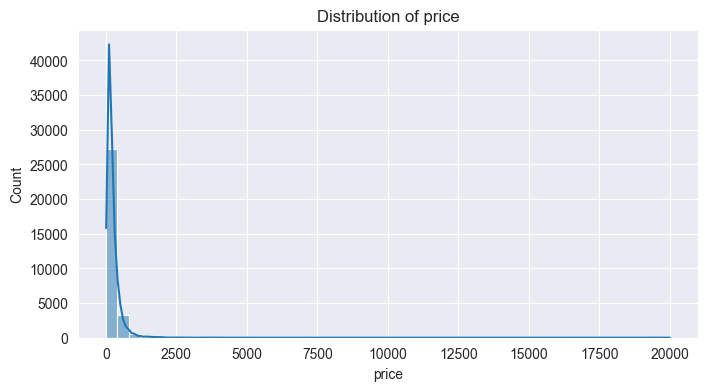

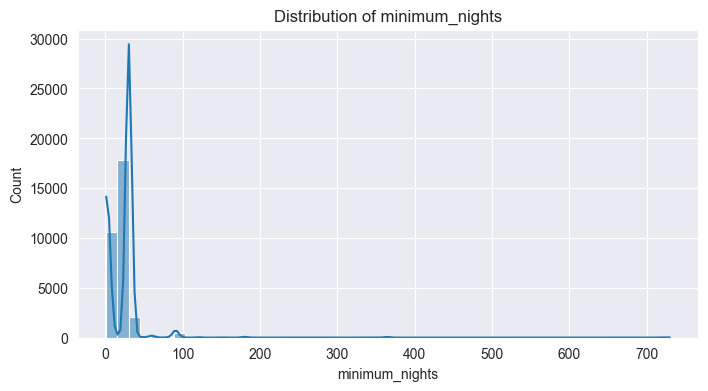

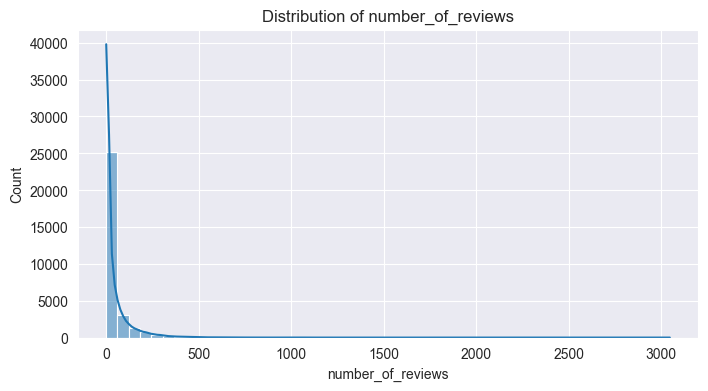

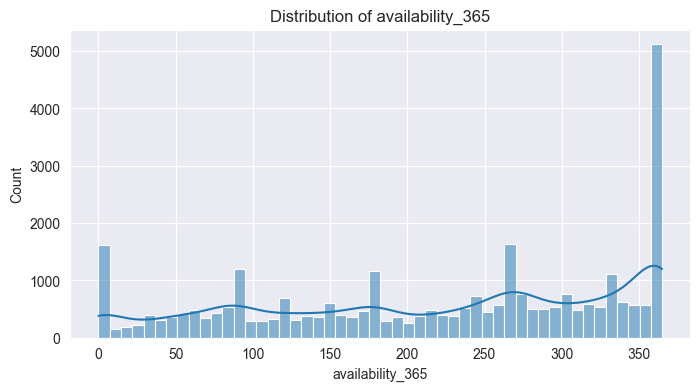

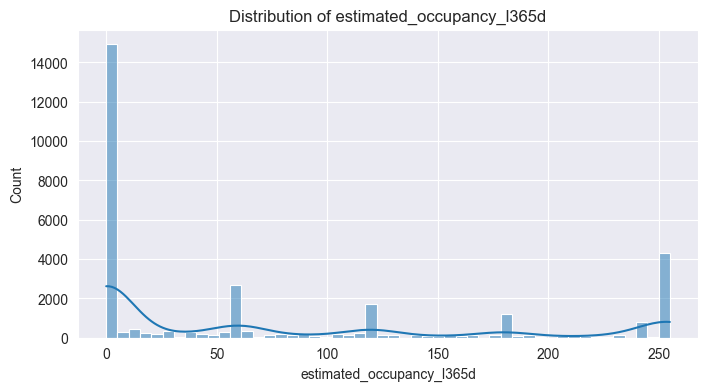

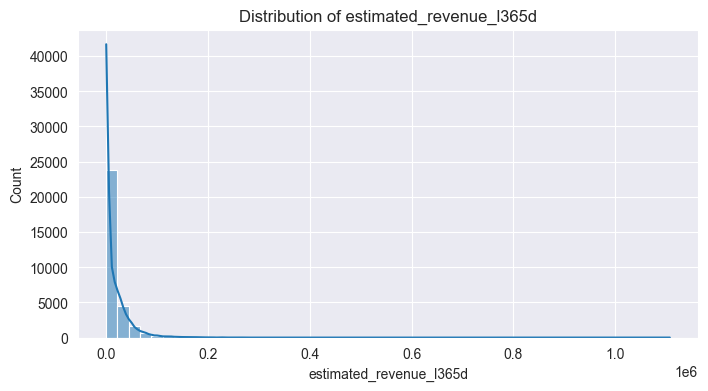

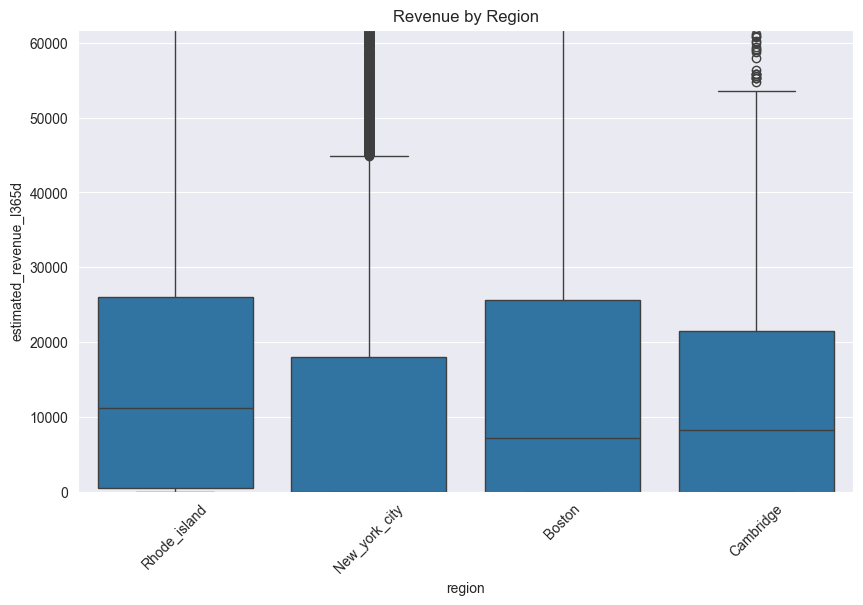

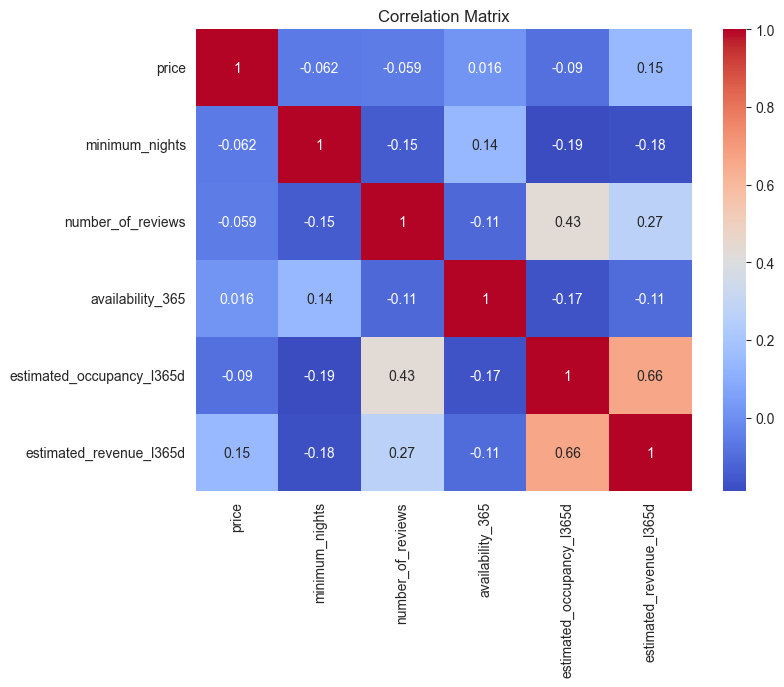

In [6]:
num_features = ['price', 'minimum_nights', 'number_of_reviews', 'availability_365', 'estimated_occupancy_l365d', 'estimated_revenue_l365d']
for feature in num_features:
    plt.figure(figsize=(8,4))
    sns.histplot(data[feature].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='region', y='estimated_revenue_l365d', data=data)
plt.xticks(rotation=45)
plt.title("Revenue by Region")
plt.ylim(0, data['estimated_revenue_l365d'].quantile(0.95))
plt.show()

corr_matrix = data[num_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Feature Engineering

In [7]:
import pandas as pd
import numpy as np
import ast
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Boolean & Percent Cleaning

for pct_col in ['host_response_rate', 'host_acceptance_rate']:
    if pct_col in data.columns:
        data[pct_col] = data[pct_col].replace('%', '', regex=True).astype(float)

bool_mappings = {'t': 1, 'f': 0}
data['host_is_superhost'] = data['host_is_superhost'].map(bool_mappings).fillna(0).astype(int)
data['host_has_profile_pic'] = data['host_has_profile_pic'].map(bool_mappings).fillna(0).astype(int)
data['host_identity_verified'] = data['host_identity_verified'].map(bool_mappings).fillna(0).astype(int)
data['instant_bookable'] = data['instant_bookable'].map(bool_mappings).fillna(0).astype(int)

# === 2. Host Response Time Encoding ===

response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
data['host_response_time'] = data['host_response_time'].map(response_time_mapping).fillna(0).astype(int)

# Host Verifications Encoding

verification_options = ['email', 'phone', 'work_email']
for v in verification_options:
    data[f'verification_{v}'] = data['host_verifications'].apply(lambda x: int(v in str(x)))

# Property Type Simplification

property_counts = data['property_type'].value_counts()
common_types = property_counts[property_counts > 100].index
data['property_type'] = data['property_type'].apply(lambda x: x if x in common_types else 'Other').fillna('Other')

# Label Encode Property Type
le_property_type = LabelEncoder()
data['property_type'] = le_property_type.fit_transform(data['property_type'])

# Bathrooms Decomposition

def decompose_bathrooms(text):
    private_full = shared_full = private_half = shared_half = 0
    if pd.isna(text): return pd.Series([private_full, shared_full, private_half, shared_half])

    match = re.search(r'(\d*\.?\d+)', text)
    count = float(match.group(1)) if match else 1

    is_shared = 'shared' in text.lower()
    is_half = 'half' in text.lower()

    if is_half:
        if is_shared: shared_half = count
        else: private_half = count
    else:
        if is_shared: shared_full = count
        else: private_full = count

    return pd.Series([private_full, shared_full, private_half, shared_half])

bathroom_decomposed = data['bathrooms_text'].apply(decompose_bathrooms)
bathroom_decomposed.columns = ['private_full_bath_count', 'shared_full_bath_count', 'private_half_bath_count', 'shared_half_bath_count']
data = pd.concat([data, bathroom_decomposed], axis=1)

def reconcile_bathrooms(row):
    parsed_total = row['private_full_bath_count'] + row['shared_full_bath_count'] + 0.5 * (row['private_half_bath_count'] + row['shared_half_bath_count'])
    if np.isnan(row['bathrooms']): return 0
    return 0 if abs(parsed_total - row['bathrooms']) <= 0.1 else 1

data['bathroom_mismatch_flag'] = data.apply(reconcile_bathrooms, axis=1)

# Host Tenure in Days

today = pd.Timestamp('today')
data['host_since_days'] = (today - data['host_since']).dt.days.fillna(0).astype(int)

# Encode Remaining Categoricals

for col in ['region', 'room_type']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Amenities Full Expansion

# Parse amenities column
def parse_amenities(amenities_str):
    try:
        items = ast.literal_eval(amenities_str)
        return [item.strip() for item in items]
    except Exception:
        return []

data['amenities_list'] = data['amenities'].apply(parse_amenities)

# Collect all unique amenities
all_amenities = set()
for amenities in data['amenities_list']:
    all_amenities.update(amenities)

# Normalize amenity column names
def clean_amenity_name(amenity):
    return 'amenity_' + re.sub(r'\W+', '_', amenity).lower()

# Create one-hot columns for all amenities
for amenity in all_amenities:
    col_name = clean_amenity_name(amenity)
    data[col_name] = data['amenities_list'].apply(lambda x: int(amenity in x))

# Drop original amenities columns
data.drop(['amenities', 'amenities_list'], axis=1, inplace=True)

# Feature building
amenity_cols = [col for col in data.columns if col.startswith('amenity_')]
bathroom_cols = list(bathroom_decomposed.columns)

features = ['price', 'minimum_nights', 'availability_365', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
            'host_is_superhost', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
            'host_listings_count', 'host_total_listings_count',
            'host_has_profile_pic', 'host_identity_verified', 'host_since_days',
            'property_type', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
            'review_count', 'sentiment', 'avg_review_length', 'region', 'room_type',
            'instant_bookable', 'availability_30', 'availability_60', 'availability_90'
            ] + [f'verification_{v}' for v in verification_options] + bathroom_cols + amenity_cols

# Final Numeric Conversion with Null Handling
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)

## Modeling

In [8]:
X = data[features]
y = data['estimated_revenue_l365d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: ${rmse:,.2f}")
print(f"R²: {r2:.3f}")

Random Forest RMSE: $13,028.66
R²: 0.776


## Feature Importance

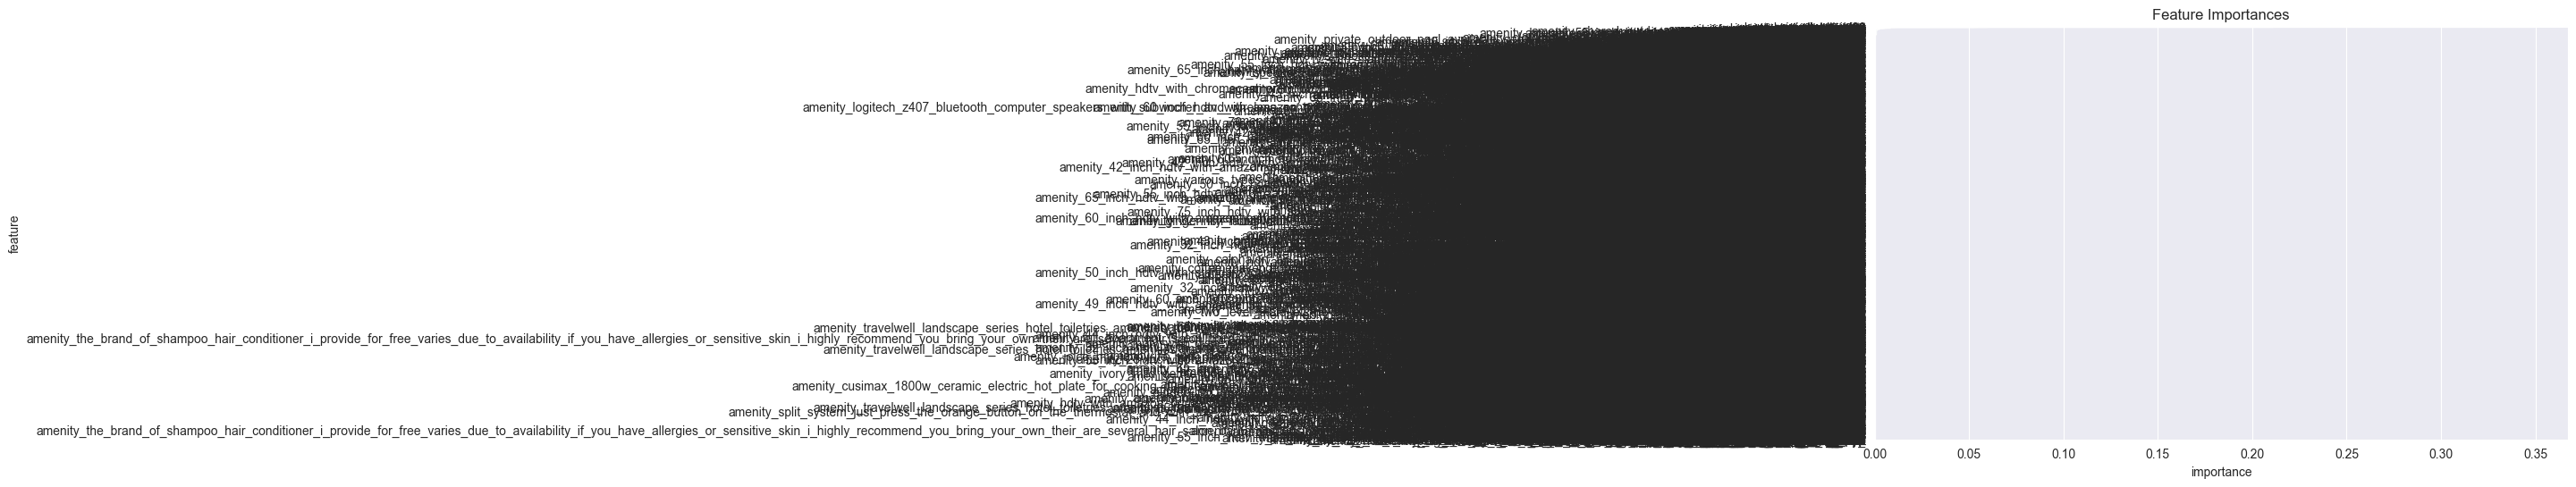

In [9]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importances, x='importance', y='feature')
plt.title("Feature Importances")
plt.show()

## Snapshot Save

In [10]:
os.makedirs("snapshots", exist_ok=True)

data.to_csv("snapshots/airbnb_prepared_data.csv", index=False)
X_train.to_csv("snapshots/X_train.csv", index=False)
X_test.to_csv("snapshots/X_test.csv", index=False)
y_train.to_csv("snapshots/y_train.csv", index=False, header=True)
y_test.to_csv("snapshots/y_test.csv", index=False, header=True)

print("Snapshot saved successfully.")

✅ Snapshot saved successfully.


In [11]:
data = pd.read_csv('snapshots/airbnb_prepared_data.csv')
all_columns = list(data.columns)
unused_columns = sorted(list(set(all_columns) - set(features)))
print(unused_columns)

['availability_eoy', 'bathroom_mismatch_flag', 'bathrooms_text', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'description', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'first_review', 'has_availability', 'host_since', 'host_verifications', 'id', 'last_review', 'maximum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights', 'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights_avg_ntm', 'name', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'number_of_reviews', 'number_of_reviews_l30d', 'number_of_reviews_ltm', 'number_of_reviews_ly', 'reviews_per_month']


In [12]:
# Print top 30 most important features
top_n = 30
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances.head(top_n).to_string(index=False))

                     feature  importance
                       price    0.349507
                review_count    0.210979
              minimum_nights    0.059503
        host_acceptance_rate    0.054269
                      region    0.052597
             host_since_days    0.029762
             availability_30    0.012157
           avg_review_length    0.010467
             availability_90    0.010234
                   sentiment    0.009775
            availability_365    0.009151
             availability_60    0.008072
           host_is_superhost    0.006516
         review_scores_value    0.005396
        review_scores_rating    0.004900
               property_type    0.004849
   host_total_listings_count    0.004833
         host_listings_count    0.004668
      review_scores_location    0.004556
                accommodates    0.004150
   review_scores_cleanliness    0.004119
      review_scores_accuracy    0.003586
       review_scores_checkin    0.003550
                

In [13]:
# Create log-revenue column
data['log_revenue'] = np.log1p(data['estimated_revenue_l365d'])
X = data[features]
y = data['log_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Convert back to dollars for easier interpretation
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Random Forest RMSE: ${rmse:,.2f}")
print(f"R²: {r2:.3f}")

In [44]:
importances = rf.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df.head(20))

                      feature  importance
26          avg_review_length    0.294986
10       host_acceptance_rate    0.193843
24               review_count    0.157927
1              minimum_nights    0.060456
0                       price    0.021375
32            availability_90    0.017977
15            host_since_days    0.012100
2            availability_365    0.011521
25                  sentiment    0.011276
12  host_total_listings_count    0.011257
11        host_listings_count    0.010100
7           host_is_superhost    0.009507
31            availability_60    0.009471
23        review_scores_value    0.006290
19  review_scores_cleanliness    0.005906
22     review_scores_location    0.005847
17       review_scores_rating    0.005087
18     review_scores_accuracy    0.005062
16              property_type    0.005041
20      review_scores_checkin    0.004862


In [45]:
# Print top 30 most important features
top_n = 30
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances.head(top_n).to_string(index=False))

                       feature  importance
             avg_review_length    0.294986
          host_acceptance_rate    0.193843
                  review_count    0.157927
                minimum_nights    0.060456
                         price    0.021375
               availability_90    0.017977
               host_since_days    0.012100
              availability_365    0.011521
                     sentiment    0.011276
     host_total_listings_count    0.011257
           host_listings_count    0.010100
             host_is_superhost    0.009507
               availability_60    0.009471
           review_scores_value    0.006290
     review_scores_cleanliness    0.005906
        review_scores_location    0.005847
          review_scores_rating    0.005087
        review_scores_accuracy    0.005062
                 property_type    0.005041
         review_scores_checkin    0.004862
   review_scores_communication    0.004395
               availability_30    0.003711
           

In [15]:
os.makedirs("snapshots", exist_ok=True)

data.to_csv("snapshots/airbnb_prepared_data.csv", index=False)
X_train.to_csv("snapshots/X_train.csv", index=False)
X_test.to_csv("snapshots/X_test.csv", index=False)
y_train.to_csv("snapshots/y_train.csv", index=False, header=True)
y_test.to_csv("snapshots/y_test.csv", index=False, header=True)

print("✅ Snapshot saved successfully.")

✅ Snapshot saved successfully.


In [50]:

# Go back to the original revenue target
y = data['estimated_revenue_l365d']

In [56]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Train/Test Split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale Features for ElasticNet

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Random Forest

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_raw, y_train)
y_pred_rf = rf.predict(X_test_raw)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest  - RMSE: ${rmse_rf:,.2f}  R²: {r2_rf:.3f}")

# HistGradientBoosting

hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train_scaled, y_train)
y_pred_hgb = hgb.predict(X_test_scaled)
rmse_hgb = np.sqrt(mean_squared_error(y_test, y_pred_hgb))
r2_hgb = r2_score(y_test, y_pred_hgb)
print(f"HistGradientBoosting  - RMSE: ${rmse_hgb:,.2f}  R²: {r2_hgb:.3f}")

# ElasticNet

en = ElasticNet(random_state=42)
en.fit(X_train_scaled, y_train)
y_pred_en = en.predict(X_test_scaled)
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
r2_en = r2_score(y_test, y_pred_en)
print(f"ElasticNet  - RMSE: ${rmse_en:,.2f}  R²: {r2_en:.3f}")

Random Forest  - RMSE: $12,978.97  R²: 0.778
HistGradientBoosting  - RMSE: $13,753.88  R²: 0.751
ElasticNet  - RMSE: $23,324.33  R²: 0.283
